Task:
1. Run the notebook as written https://github.com/jpata/particleflow/blob/int8_quant/notebooks/clic/mlpf-pytorch-transformer-standalone.ipynb 
    1. Understand everything
    2. recompute the loss using the quantized model for larger number of samples
    3. To understand the contributions of loss you can check the regression and classification loss seperately.
    3. add more physics validation checks
    4. Sticking with 'x86' try to work on fine-tuning of qconfig


In [3]:
import torch
torch.set_num_threads(1)
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [4]:
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

#Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [5]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

In [19]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

class QuantizeFeaturesStub(torch.nn.Module):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
def mlpf_loss(y, ypred):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    npart = y["pt"].numel()

    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = 100 * loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = 10 * torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all particles
    loss["Classification"] = loss_classification.sum() / npart
    loss["Regression"] = loss_regression.sum() / npart
    print(f'classification', loss["Classification"])
    print(f'regression', loss["Regression"])

    loss["Total"] = loss["Classification"] + loss["Regression"]
    print(f'Total loss', loss["Total"])
    return loss
    
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU()
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act, nn.Linear(width, embedding_dim), self.act
        )

        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
#         mask = mask.to(x.dtype)        
#         x = x * mask.unsqueeze(-1).expand(-1, -1, x.size(2))

        
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU  # Change activation function here
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum


model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [20]:
# torch.set_grad_enabled(True)  # Context-manager 


In [21]:
max_events_train = 1000
max_events_eval = 1000
events_per_batch = 10

losses = []

#Training loop
inds_train = range(0,max_events_train,events_per_batch)
loss_vals = []

for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind,ind+events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0]!=0

    preds = model(X_features_padded, mask)
    preds_unpacked_unq = unpack_predictions(preds)
    targets_unpacked_unq = unpack_target(y_targets_padded)
    
    loss = mlpf_loss(targets_unpacked_unq, preds_unpacked_unq)
    loss["Total"].backward()
    optimizer.step()
    current_loss = loss["Total"].detach().item()
    losses.append(current_loss)
    print("Loss={:.2f}".format(loss["Total"].detach().item()))

Loss=155.23
Loss=123.46
Loss=89.45
Loss=96.62
Loss=73.19
Loss=75.12
Loss=87.52
Loss=77.18
Loss=67.36
Loss=69.89
Loss=72.84
Loss=76.07
Loss=69.45
Loss=88.33
Loss=69.88
Loss=70.09
Loss=59.19
Loss=55.33
Loss=64.51
Loss=72.77
Loss=46.86
Loss=59.42
Loss=50.22
Loss=61.57
Loss=68.01
Loss=64.40
Loss=54.55
Loss=58.13
Loss=52.28
Loss=63.64
Loss=55.36
Loss=44.04
Loss=54.39
Loss=49.73
Loss=50.17
Loss=47.59
Loss=45.60
Loss=51.65
Loss=50.15
Loss=40.24
Loss=52.90
Loss=45.78
Loss=46.76
Loss=37.63
Loss=47.76
Loss=45.85
Loss=49.82
Loss=50.32
Loss=46.68
Loss=43.60
Loss=45.43
Loss=42.18
Loss=32.32
Loss=40.34
Loss=43.29
Loss=40.46
Loss=32.17
Loss=36.47
Loss=41.74
Loss=37.30
Loss=44.58
Loss=39.63
Loss=39.91
Loss=40.11
Loss=39.79
Loss=36.98
Loss=44.50
Loss=37.26
Loss=49.72
Loss=36.88
Loss=40.98
Loss=37.53
Loss=42.94
Loss=37.81
Loss=38.90
Loss=40.75
Loss=36.38
Loss=33.50
Loss=33.61
Loss=31.63
Loss=33.10
Loss=32.33
Loss=32.85
Loss=35.19
Loss=33.86
Loss=34.94
Loss=33.83
Loss=32.21
Loss=34.55
Loss=36.78
Loss=36.

In [ ]:
# print(mask.shape)

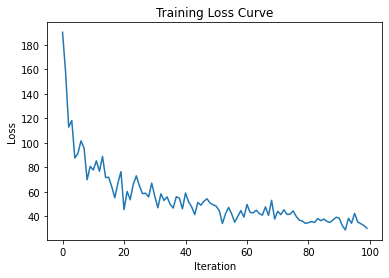

In [9]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
# losses

## Quantized model

In [10]:
# torch.backends.quantized.engine = 'onednn'

model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
model_prepared = torch.ao.quantization.prepare(model)


#calibrate on data
num_events_to_calibrate = 1
for ind in range(1000,1000+num_events_to_calibrate):
    X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    mask = X[:, :, 0]!=0
    model_prepared(X, mask)

model_int8 = torch.ao.quantization.convert(model_prepared)

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


## Training on the quantized model

In [11]:
model_int8

MLPF(
  (nn0_id): Sequential(
    (0): QuantizedLinear(in_features=17, out_features=256, scale=17.288698196411133, zero_point=68, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): QuantizedDropout(p=0.0, inplace=False)
    (4): QuantizedLinear(in_features=256, out_features=256, scale=0.03569576516747475, zero_point=69, qscheme=torch.per_channel_affine)
  )
  (nn0_reg): Sequential(
    (0): QuantizedLinear(in_features=17, out_features=256, scale=20.763954162597656, zero_point=71, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): QuantizedDropout(p=0.0, inplace=False)
    (4): QuantizedLinear(in_features=256, out_features=256, scale=0.03111262619495392, zero_point=64, qscheme=torch.per_channel_affine)
  )
  (conv_id): ModuleList(
    (0): SelfAttentionLayer(
      (act): ReLU()
      (mha): QuantizedMultiheadAttention(
        (

classification tensor(122.5970)
classification tensor(3.4397)
Total loss tensor(126.0367)
Loss=126.04
classification tensor(122.6972)
classification tensor(2.9952)
Total loss tensor(125.6924)
Loss=125.69
classification tensor(121.8849)
classification tensor(2.4634)
Total loss tensor(124.3483)
Loss=124.35
classification tensor(122.7388)
classification tensor(4.5265)
Total loss tensor(127.2653)
Loss=127.27
classification tensor(122.0704)
classification tensor(2.9142)
Total loss tensor(124.9846)
Loss=124.98
classification tensor(122.2450)
classification tensor(3.4814)
Total loss tensor(125.7264)
Loss=125.73
classification tensor(122.6516)
classification tensor(4.6377)
Total loss tensor(127.2893)
Loss=127.29
classification tensor(122.5752)
classification tensor(4.2769)
Total loss tensor(126.8521)
Loss=126.85
classification tensor(122.0044)
classification tensor(3.6601)
Total loss tensor(125.6645)
Loss=125.66
classification tensor(122.5522)
classification tensor(3.2466)
Total loss tensor(12

classification tensor(122.1720)
classification tensor(3.5528)
Total loss tensor(125.7248)
Loss=125.72
classification tensor(122.1201)
classification tensor(3.5591)
Total loss tensor(125.6792)
Loss=125.68
classification tensor(122.4754)
classification tensor(3.4831)
Total loss tensor(125.9585)
Loss=125.96
classification tensor(122.2484)
classification tensor(3.7255)
Total loss tensor(125.9739)
Loss=125.97
classification tensor(122.4637)
classification tensor(3.2031)
Total loss tensor(125.6668)
Loss=125.67
classification tensor(122.2160)
classification tensor(4.0647)
Total loss tensor(126.2808)
Loss=126.28
classification tensor(122.3675)
classification tensor(4.1453)
Total loss tensor(126.5127)
Loss=126.51
classification tensor(122.6147)
classification tensor(3.0485)
Total loss tensor(125.6632)
Loss=125.66
classification tensor(122.5678)
classification tensor(3.5332)
Total loss tensor(126.1009)
Loss=126.10
classification tensor(122.2823)
classification tensor(5.3489)
Total loss tensor(12

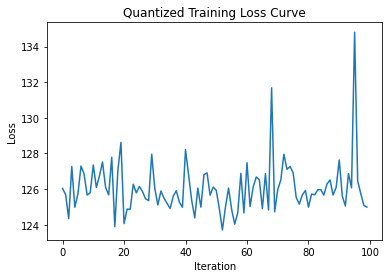

In [12]:
max_events_train = 1000
events_per_batch = 10
quantized_losses = []

# Training loop
inds_train = range(0, max_events_train, events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0] != 0

    preds = model_int8(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)

    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    
    # Ensure all tensors contributing to the loss have requires_grad = True
    for key, value in loss.items():
        if value.requires_grad is False:
            value.requires_grad = True

    loss_total = loss["Total"].sum()  
    loss_total.backward()
    optimizer.step()

    current_loss = loss_total.detach().item()
    quantized_losses.append(current_loss)
    print("Loss={:.2f}".format(current_loss))

# Plot
plt.plot(quantized_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Quantized Training Loss Curve')
plt.show()


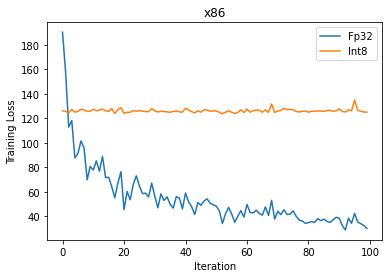

In [13]:
plt.plot(losses, label='Fp32')
plt.plot(quantized_losses, label='Int8')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()
# plt.title('Quantized Training Loss Curve')
plt.title('x86')
plt.show()


In [14]:
X_data_quantized = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
X_data_quantized_padded = pad_sequence(X_data_quantized, batch_first=True)
mask_quantized = X_data_quantized_padded[:, :, 0] != 0  
#pred
with torch.no_grad():
    preds_quantized = model_int8(X_data_quantized_padded, mask_quantized)
    
preds_quantized_unpacked = unpack_predictions(preds_quantized)
targets_unpacked = unpack_target(y_targets_padded)

#loss
loss_quantized = mlpf_loss(targets_unpacked, preds_quantized_unpacked)

print("Quantized Model Loss with x86: {:.2f}".format(loss_quantized["Total"].item()))


classification tensor(122.1236)
classification tensor(2.8665)
Total loss tensor(124.9901)
Quantized Model Loss with x86: 124.99


**Quantized Model Loss with onednn: 121.74 \
Quantized Model Loss with x86: 125.51 \
Unquantized model loss: 29.26**

**Dataset Information:**

X: the reconstruction input features, i.e. tracks and clusters

ygen: the ground truth particles with the features ["PDG", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy", "jet_idx"], with "jet_idx" corresponding to the gen-jet assignment of this particle

https://zenodo.org/records/8409592

**To Do:**
* ultimately reproduce Fig 9 from the [paper](https://arxiv.org/pdf/2309.06782.pdf), adding additional an int8-quantized MLPF model (e.g. dashed orange line)

In [31]:
targets_unpacked['pt'].shape

torch.Size([10, 248])

In [37]:
targets_unpacked_unq['pt'].shape

torch.Size([10, 201])

In [38]:
targets_unpacked['pt']

tensor([[29.3308, 16.3776, 11.0753,  ...,  0.0000,  0.0000,  0.0000],
        [11.4296, 11.2534,  7.4814,  ...,  0.0000,  0.0000,  0.0000],
        [81.4108, 19.7446,  3.0669,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [11.9754, 11.1559,  7.4632,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.0538, 11.2622, 11.8753,  ...,  0.0000,  0.0000,  0.0000],
        [ 4.5375, 30.6604, 13.4644,  ...,  0.0000,  0.0000,  0.0000]])

In [39]:
targets_unpacked_unq['pt']

tensor([[ 5.2084, 10.8834,  9.6858,  ...,  0.0000,  0.0000,  0.0000],
        [12.7611, 10.4114, 10.9317,  ...,  0.0000,  0.0000,  0.0000],
        [10.4192, 14.1023,  1.7646,  ..., 11.3411,  4.4822,  0.0000],
        ...,
        [ 3.9776, 19.7735, 11.2324,  ...,  0.0000,  0.0000,  0.0000],
        [ 8.0681,  7.6773, 21.1527,  ...,  0.0000,  0.0000,  0.0000],
        [11.5500, 48.6111,  8.4631,  ...,  0.0000,  0.0000,  0.0000]])

In [49]:
min_val = torch.min(targets_unpacked['pt']).item()
max_val = torch.max(targets_unpacked['pt']).item()


In [50]:
min_val, max_val 

(0.0, 81.4107666015625)

In [51]:
min_val = torch.min(targets_unpacked_unq['pt']).item()
max_val = torch.max(targets_unpacked_unq['pt']).item()


In [52]:
min_val, max_val 

(0.0, 81.24093627929688)

```python
msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)        
px = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 3:4] * msk_true_particle
py = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 2:3] * msk_true_particle
pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

px = y["momentum"][..., 0:1] * y["momentum"][..., 3:4] * msk_true_particle
py = y["momentum"][..., 0:1] * y["momentum"][..., 2:3] * msk_true_particle
true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)
```
        
        
if you do something like this, you can compute the true and predicted MET


and compare their distributions and response=pred_met/true_met

In [7]:

msk_true_particle = torch.unsqueeze((targets_unpacked_unq["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
px = preds_unpacked_unq["momentum"][..., 0:1] * preds_unpacked_unq["momentum"][..., 3:4] * msk_true_particle
py = preds_unpacked_unq["momentum"][..., 0:1] * preds_unpacked_unq["momentum"][..., 2:3] * msk_true_particle
# pred_met is \sqrt(px**2+py**2)
px_sum = torch.sum(px, axis=-2)
py_sum = torch.sum(py, axis=-2)
pred_met = torch.sqrt(px_sum ** 2 + py_sum ** 2)

NameError: name 'targets_unpacked_unq' is not defined

In [60]:
pred_met

tensor([[17.0119],
        [61.4280],
        [30.6598],
        [16.8550],
        [ 3.2127],
        [73.5539],
        [90.8664],
        [57.6672],
        [40.3295],
        [ 3.8403]], grad_fn=<SqrtBackward0>)

In [68]:
# Compute msk_true_particle for y tensor
msk_true_particle_y = torch.unsqueeze((yp["cls_id"] != 0).to(dtype=torch.float32), axis=-1)

# Compute px for y
px_y = y["momentum"][..., 0:1] * y["momentum"][..., 3:4] * msk_true_particle_y

# Compute py for y
py_y = y["momentum"][..., 0:1] * y["momentum"][..., 2:3] * msk_true_particle_y

# Compute true_met
px_sum_y = torch.sum(px_y, axis=-2)
py_sum_y = torch.sum(py_y, axis=-2)
true_met = torch.sqrt(px_sum_y ** 2 + py_sum_y ** 2)

NameError: name 'y' is not defined

In [66]:
y_targets_padded

tensor([[[ 1.0000e+00,  1.0000e+00,  2.1273e+01,  ...,  9.6941e-01,
           2.2023e+01,  3.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.8855e+01,  ..., -5.9503e-01,
           2.0037e+01,  2.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.2961e+01,  ...,  4.2384e-01,
           1.2973e+01,  5.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 1.0000e+00,  1.0000e+00,  1.6827e+00,  ..., -9.9965e-01,
           1.8183e+00,  3.0000e+00],
         [ 1.0000e+00, -1.0000e+00,  1.0281e+01,  ..., -3.4482e-02,
           1.0299e+01,  2.0000e+00],
         [ 1.0000e+00, -1.0000e+00,  1.0511e+01,  ...,  9.0784e-01,
           1.4937e+01,  4.0000e+00],
         ...,
         [ 0.0000e+00,  0

---
---
---

In [ ]:
model_fp16 = model.to(torch.float16)

model_fp16

model_fp16 = model.to(torch.float16)
model_quantized_fp16 = torch.quantization.quantize_dynamic(
    model_fp16, {torch.nn.Linear}, dtype=torch.float16
)


model_quantized_fp16

In [ ]:
max_events_train = 1000
events_per_batch = 10
quantized_losses = []

# Training loop
inds_train = range(0, max_events_train, events_per_batch)
for ind in inds_train:
    optimizer.zero_grad()
    ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    
    mask = X_features_padded[:, :, 0] != 0

    preds = model_int8(X_features_padded, mask)
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)

    loss = mlpf_loss(targets_unpacked, preds_unpacked)
    
    # Ensure all tensors contributing to the loss have requires_grad = True
    for key, value in loss.items():
        if value.requires_grad is False:
            value.requires_grad = True

    # Convert the loss tensor to a scalar before calling backward
    loss_total = loss["Total"].sum()  
    loss_total.backward()
    optimizer.step()

    current_loss = loss_total.detach().item()
    losses.append(current_loss)
    print("Loss={:.2f}".format(current_loss))


plt.plot(quantized_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Quantized Training Loss Curve')
plt.show()

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    losses_quantized = []

    for ind in inds_train:
        optimizer.zero_grad()
        ds_elems = [ds_train[i] for i in range(ind, ind + events_per_batch)]
        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
        X_features_padded = pad_sequence(X_features, batch_first=True)
        y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
        y_targets_padded = pad_sequence(y_targets, batch_first=True)

        mask = X_features_padded[:, :, 0] != 0

        preds = model_int8(X_features_padded, mask)  # Use quantized model here
        preds_unpacked = unpack_predictions(preds)
        targets_unpacked = unpack_target(y_targets_padded)
        loss = mlpf_loss(targets_unpacked, preds_unpacked)
        
        # Ensure all tensors contributing to the loss have requires_grad = True
        for key, value in loss.items():
            if value.requires_grad is False:
                value.requires_grad = True
        
        loss["Total"].backward()
        optimizer.step()
        current_loss = loss["Total"].detach().item()
        losses_quantized.append(current_loss)
        print("Iteration: {}, Loss: {:.2f}".format(ind, loss["Total"].detach().item()))

    # Plot training loss
    plt.plot(losses_quantized)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve (Quantized Model) - Epoch {}'.format(epoch + 1))
    plt.show()


In [ ]:
# Plotting both losses on the same plot
plt.plot(losses, label='Original Model')
plt.plot(quantized_losses, label='Quantized Model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not str